In [1]:
from pyrosm.data import sources
import pyrosm
from collections import Counter, defaultdict
import json
import pandas as pd
import ast
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import random

In [2]:
def parse_tags(val):
    if pd.isna(val) or val in ["None", "nan", None]:
        return {}
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    
    except json.JSONDecodeError:
        return {}

def create_tag_lists(pois, n):
    tag_freq = defaultdict(int)
    #print(tag_freq)



    for idx, row in pois.iterrows(): 
        tags = row.get("tags", {})
        #print(f"Row {idx}, Tags: {tags}, Type: {type(tags)}")  # Check type of tags

        if isinstance(tags, dict) and tags:
            for tag_key in tags:
                tag_freq[tag_key] += 1


    # print(tag_freq)
    all_tags = list(tag_freq.keys())
    all_good_tags = [tag for tag in tag_freq if tag_freq[tag] > n]
    tag2idx = {tag: i for i, tag in enumerate(all_good_tags)}
    idx2tag = {i: tag for tag, i in tag2idx.items()}

    tag_freq = dict(sorted(tag_freq.items(), key = lambda x: x[1], reverse = True))
    print(f"All tags sorted by frequency: {tag_freq}")
    print(f" All allowed tags: {all_good_tags}")
    # print(tag2idx)
    # print(idx2tag)
    print(f"Len all tags: {len(all_tags)}, Len good tags: {len(all_good_tags)}")
    #print("\n Returning (all_good_tags, tag2idx)")


    return (all_good_tags, tag2idx, tag_freq)

def tags_to_vec(tag_dict, tag2idx):
    vector = np.zeros(len(tag2idx), dtype= np.float32)
    if isinstance(tag_dict, dict):
        for tag in tag_dict:
            if tag in tag2idx:
                vector[tag2idx[tag]] = 1
    return vector

def remove_bad_tags(good_tags, pois):
    for i in pois["tags"]:
        remove_list = []
        for j in i:
            if j not in good_tags:
                remove_list.append(j)
        for removable in remove_list:
            #print(f"removing {removable} from {i}")
            i.pop(removable)
            #print(f"after remnoval: {i}")     

In [3]:
fp = pyrosm.get_data("Amsterdam")
osm = pyrosm.OSM(fp)
pois = osm.get_pois()
pois["tags"] = pois["tags"].apply(parse_tags) #only need to run it once

In [4]:
n_good_tags = 10 # Frequency of tags for them to be allowed
print(len(pois["tags"]))
good_tags, tag2idx, tag_freq = create_tag_lists(pois, n_good_tags)
#remove_bad_tags(good_tags, pois)

129613
All tags sorted by frequency: {'surface': 23489, 'capacity': 23395, 'parking_space': 15959, 'access': 15064, 'smoothness': 14279, 'source:date': 13407, 'fee': 10521, 'orientation': 9417, 'wheelchair': 6807, 'backrest': 6590, 'recycling_type': 4710, 'check_date': 4691, 'brand': 4667, 'brand:wikidata': 4477, 'maxstay:conditional': 3993, 'material': 3810, 'lit': 3269, 'cuisine': 3093, 'operator:wikidata': 2888, 'covered': 2866, 'brand:wikipedia': 2148, 'waste': 2112, 'colour': 1515, 'ref:bag': 1511, 'note': 1323, 'artwork_type': 1293, 'outdoor_seating': 1259, 'seats': 1235, 'recycling:waste': 1224, 'brand:website': 1069, 'wikidata': 1060, 'recycling:paper': 1051, 'operator:wikipedia': 925, 'takeaway': 922, 'layer': 879, 'description': 855, 'recycling:glass_bottles': 849, 'artist_name': 827, 'level': 794, 'wikimedia_commons': 716, 'healthcare': 698, 'indoor_seating': 673, 'vending': 653, 'branch': 618, 'contact:facebook': 605, 'socket:type2': 575, 'location': 572, 'denomination': 56

In [ ]:
# Keep only rows where 'tags' is more than two
#pois = pois[pois["tags"].apply(lambda x: isinstance(x, dict) and len(x) > 2)]


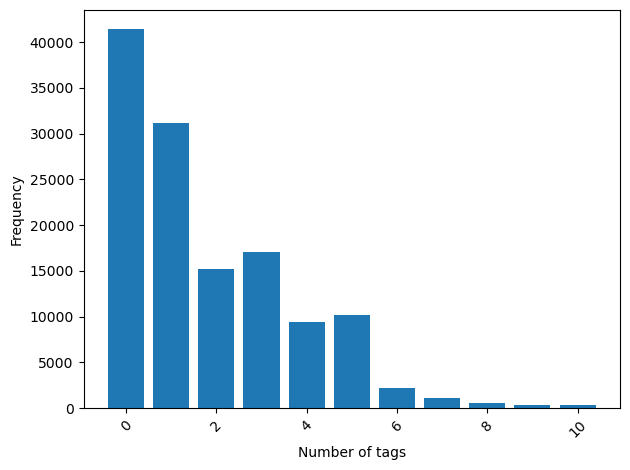

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

lengthed_list = []

for i in pois["tags"]:
    lengthed_list.append(len(i))

# Count and sort
counts = Counter(lengthed_list)
top_items = counts.most_common(11)

# Unpack into separate lists
items, values = zip(*top_items)

#items, values = zip(*counts.most_common())

# Plot
plt.bar(items, values)
plt.xlabel('Number of tags')
plt.ylabel('Frequency')
#plt.title('Histogram of Item Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.yscale("log")
plt.show()

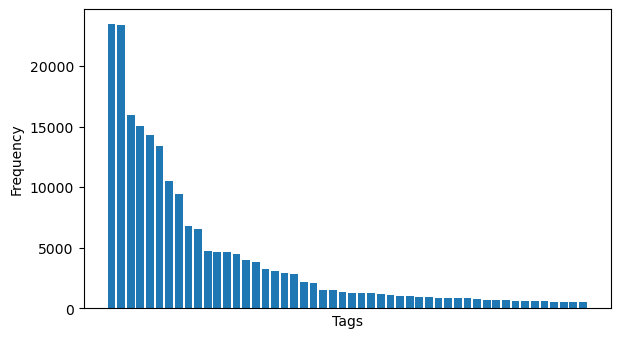

In [13]:
counts = Counter(tag_freq)
top_items = counts.most_common(50)

# Unpack into separate lists
items, values = zip(*top_items)

#items, values = zip(*counts.most_common())

# Plot
plt.bar(items, values)
plt.xlabel('Tags')
plt.ylabel('Frequency')
#plt.title('Histogram of Item Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.xticks([])
#plt.yscale("log")
plt.show()

In [18]:
final_train,  final_test = train_test_split(pois, test_size=0.2)
print(len(final_train["tags"]))
print(len(final_test["tags"]))
test_questions = []
test_answers = []
for i in final_test['tags']:
    inew = list(i.keys())
    idx = random.randint(0, len(inew)-1)
    test_answers.append(inew[idx])
    test_questions.append(inew[:idx] + inew[idx+1:])

print("q-a", len(test_questions), len(test_answers))

# with open('trainingset', 'wb') as fp:
#     pickle.dump(final_train, fp)
# with open('testset_questions', 'wb') as fb:
#     pickle.dump(test_questions, fb)
# with open('testset_answer', 'wb') as fq:
#     pickle.dump(test_answers, fq)

33426
8357
q-a 8357 8357


In [31]:
with open('trainingset', 'rb') as fp:
    trainingloaded = pickle.load(fp)

print(type(trainingloaded["tags"]))
print(type(pois['tags']))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [35]:
print(len(trainingloaded))

33163
